In [36]:
import pandas as pd
import sklearn.metrics as metrics
import numpy as np
from tensorflow import keras
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.metrics import *
from tensorflow.keras.layers import *
from keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from plot_metric.functions import BinaryClassification

In [2]:
trainDir_names=[]
trainDir_labels=[]
trainDf = pd.read_csv('train.txt', sep = " ", header = None)

In [3]:
print(trainDf.iloc[1][2])
print(len(trainDf))

negative
15951


In [4]:
for i in range(len(trainDf)):
    trainDir_names.append(trainDf.iloc[i][1])
    trainDir_labels.append(trainDf.iloc[i][2])

In [5]:
print(trainDir_labels.count('negative'))
print(trainDir_labels.count('positive'))

13793
2158


In [6]:
df = pd.DataFrame()
df['names'] = trainDir_names
df['labels'] = trainDir_labels

In [7]:
print(df.head())

                                            names    labels
0                                  ARDSSevere.png  negative
1  acute-respiratory-distress-syndrome-ards-1.jpg  negative
2    acute-respiratory-distress-syndrome-ards.jpg  negative
3          ards-secondary-to-tiger-snake-bite.png  negative
4                 pneumocystis-pneumonia-2-PA.png  negative


In [8]:
##UNO
file_count = 2158
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

negative    2158
positive    2158
Name: labels, dtype: int64
4316


In [9]:
testDf = pd.read_csv('test.txt', sep = " ",header = None)

In [10]:
testDir_names = []
testDir_labels = []

for i in range(len(testDf)):
    testDir_names.append(testDf.iloc[i][1])
    testDir_labels.append(testDf.iloc[i][2])
    
print(len(testDir_names))
print(len(testDir_labels))

print(testDir_labels.count('negative'))
print(testDir_labels.count('positive'))

testDf['names'] = testDir_names
testDf['labels'] = testDir_labels

400
400
200
200


In [11]:
def scaleftn(img):
    return img/127.5-1 #scales between -1 and 1
gen=ImageDataGenerator(preprocessing_function=scaleftn)

In [12]:
trainDf,validDf=train_test_split(df, train_size=0.9, shuffle=True, random_state=123)

In [13]:
height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)

train_gen = gen.flow_from_dataframe(trainDf, directory="./train/", x_col='names', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=gen.flow_from_dataframe(testDf, directory="./test/", x_col='names', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
valid_gen = gen.flow_from_dataframe(validDf, directory="./train/", x_col='names', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3884 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.


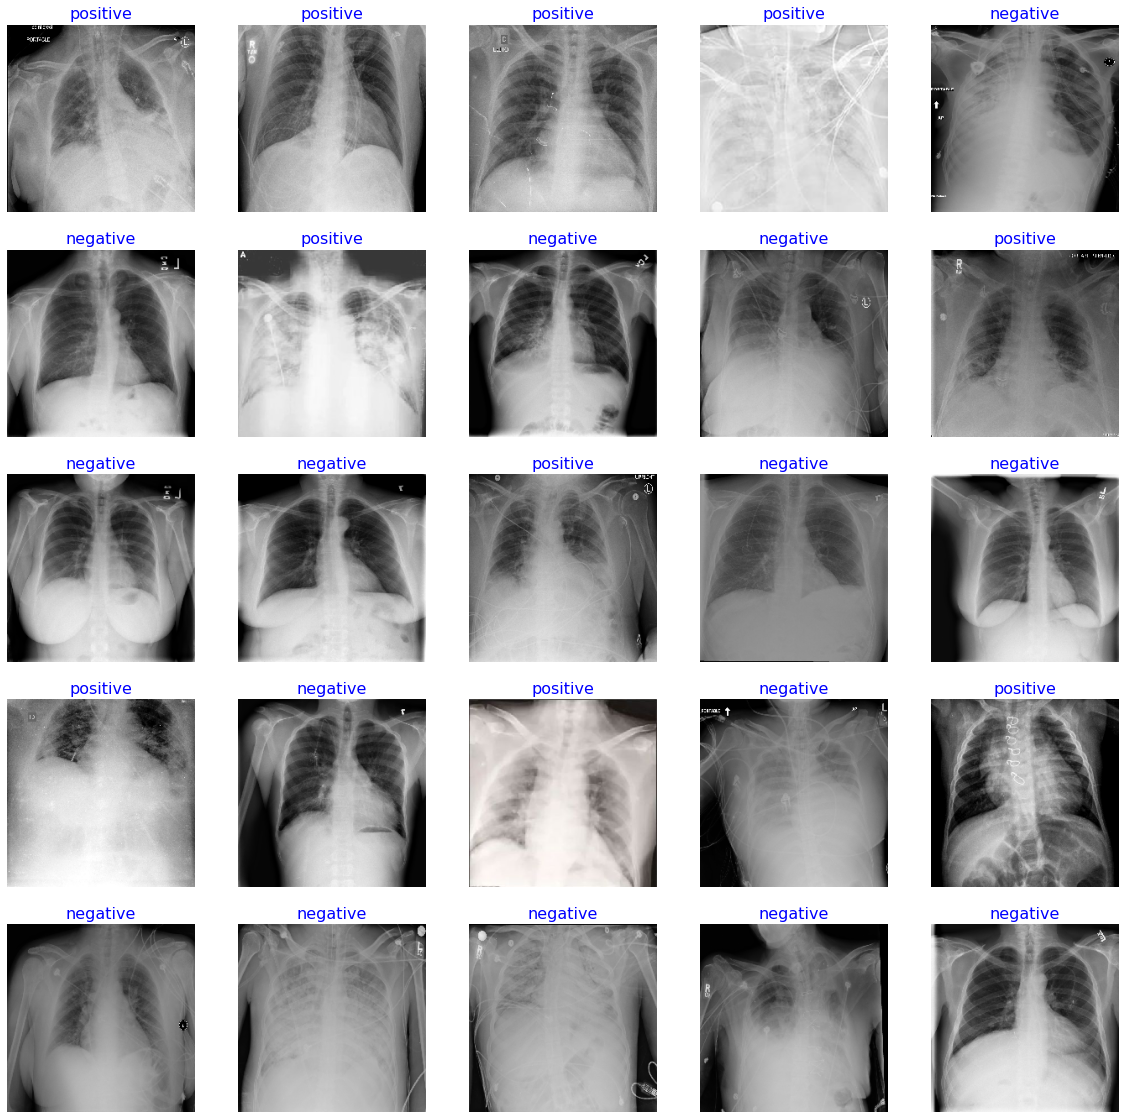

In [14]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    class_names=list( class_dict.keys())       
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

In [15]:
##UNO
def genToTuple(gen):
    templist = []
    templist2 = []
    for i in range(gen.__len__()):
        tempnext = gen.next()
        templist.append(tempnext[0])
        templist2.append(tempnext[1])
    x=np.concatenate(templist)
    y=np.concatenate(templist2)
    return (x,y)

def combine_tuple(*tuples):
    x=np.concatenate([tuples[i][0] for i in range(len(tuples))])
    y=np.concatenate([tuples[i][1] for i in range(len(tuples))])
    return (x,y.astype(int))   

train_generator1_t = genToTuple(train_gen)

test_generator1_t = genToTuple(test_gen)


x_train,y_train = combine_tuple(train_generator1_t)

x_test,y_test = combine_tuple(test_generator1_t)


In [16]:
x_val,y_val = genToTuple(valid_gen)

In [17]:
#The train shapes could prove to be an issue, maybe reduce down to 1 or 0 #see flattenTransform function
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(3884, 224, 224, 3) (3884, 2)
(400, 224, 224, 3) (400, 2)
(432, 224, 224, 3) (432, 2)


In [18]:
print(y_train)

[[0 1]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [19]:
def flattenTransform(arr):
    lst = []
    for i in range(len(arr)):
        lst.append(arr[i][0])
    lst = np.array(lst)
    return lst

In [20]:
y_train = flattenTransform(y_train)
y_test = flattenTransform(y_test)
y_val = flattenTransform(y_val)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(3884, 224, 224, 3) (3884,)
(400, 224, 224, 3) (400,)
(432, 224, 224, 3) (432,)


In [21]:
#UNO

def build_model():
        model = Sequential()
        
        model.add(Input(shape=img_shape))

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) #0.45
        
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) # 0.45
        
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
        model.add(Dropout(0.2))        
        model.add(Flatten())
        
        model.add(Dense(256)) # 1024
        model.add(Activation("relu"))
        model.add(Dropout(0.25)) #0.45
        
        model.add(Dense(128)) # 256 1024
        model.add(Activation("relu"))
        model.add(Dropout(0.2)) #0.4
        
        
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        
        optimizer = Adam ()#(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy) 
        
        return model
    
model1 = build_model() 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        2080      
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 32)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 56, 56, 32)        0

In [22]:
##UNO
mobilenet = MobileNetV2(alpha=1.4,weights='imagenet',include_top=False,input_shape=(img_shape))
for layer in mobilenet.layers:
    layer.trainable = True #False
model = Sequential()
model.add(mobilenet)
model.add(GlobalMaxPooling2D(),) # GlobalMaxPooling2D или GlobalAveragePooling2D не надо: Flatten())
model.add(Dense(256)) #512
model.add(Activation("relu"))
model.add(Dropout(0.45)) #0.25                   
model.add(Dense(1))
model.add(Activation("sigmoid")) 
model.compile(optimizer="adam",loss=binary_crossentropy, metrics =["accuracy"]) #binary_accuracy accuracy
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_max_pooling2d (Global (None, 1792)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               459008    
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                

In [23]:
reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000000001,verbose=1) #monitor='val_acc' loss
checkpoint = ModelCheckpoint("X-Ray.h5",monitor="val_accuracy",save_best_only=True,verbose=1) #
stopSign = EarlyStopping(monitor = "loss",patience=10,min_delta=0.000000000001,mode="min")
epochs = 10 
batch_size = 32 
steps_per_epoch = x_train.shape[0] // batch_size
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[stopSign,checkpoint
                               ,reducer
                              ])

Epoch 1/10
121/121 [==============================] - 566s 5s/step - loss: 1.1218 - accuracy: 0.8517 - val_loss: 0.5188 - val_accuracy: 0.8426

Epoch 00001: val_accuracy improved from -inf to 0.84259, saving model to facemask.h5
Epoch 2/10
121/121 [==============================] - 570s 5s/step - loss: 0.1132 - accuracy: 0.9634 - val_loss: 0.1474 - val_accuracy: 0.9560

Epoch 00002: val_accuracy improved from 0.84259 to 0.95602, saving model to facemask.h5
Epoch 3/10
121/121 [==============================] - 581s 5s/step - loss: 0.0762 - accuracy: 0.9766 - val_loss: 0.6063 - val_accuracy: 0.8819

Epoch 00003: val_accuracy did not improve from 0.95602
Epoch 4/10
121/121 [==============================] - 571s 5s/step - loss: 0.1080 - accuracy: 0.9658 - val_loss: 0.4317 - val_accuracy: 0.8819

Epoch 00004: val_accuracy did not improve from 0.95602
Epoch 5/10
121/121 [==============================] - 567s 5s/step - loss: 0.0874 - accuracy: 0.9746 - val_loss: 0.3130 - val_accuracy: 0.923

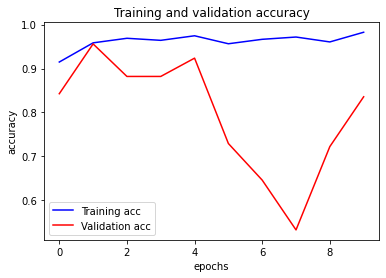

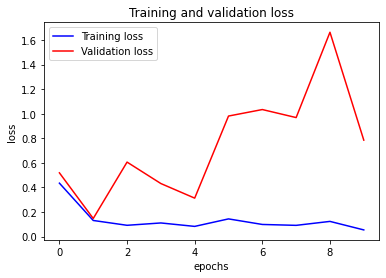

In [24]:
##UNO:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
 
plt.show()

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


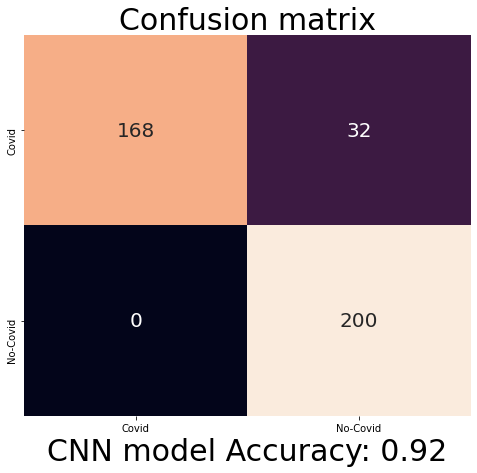

In [26]:
##UNO
labels=["Covid","No-Covid"]
y_pred_classes = model.predict_classes(x_test)
y_pred = model.predict(x_test)

plt.subplots(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test,y_pred_classes),xticklabels=labels,
                                       yticklabels=labels, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20})
plt.title("Confusion matrix",fontsize=30)
plt.xlabel(f"CNN model Accuracy: {accuracy_score(y_test,y_pred_classes)}",fontsize=30)
plt.show()

In [27]:
print(classification_report(y_test, y_pred_classes, target_names = labels)) 

              precision    recall  f1-score   support

       Covid       1.00      0.84      0.91       200
    No-Covid       0.86      1.00      0.93       200

    accuracy                           0.92       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.92      0.92       400



In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test, steps=32)
print('The final test accuracy: ',test_acc)
print('The final test loss: ',test_loss)

32/32 [==============================] - 6s 180ms/step - loss: 0.3373 - accuracy: 0.9200
The final test accuracy:  0.9200000166893005
The final test loss:  0.33727195858955383


In [32]:
y_pred_proba = model.predict_proba(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


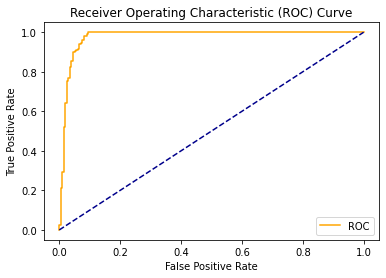

In [33]:
plot_roc_cur(fpr, tpr)

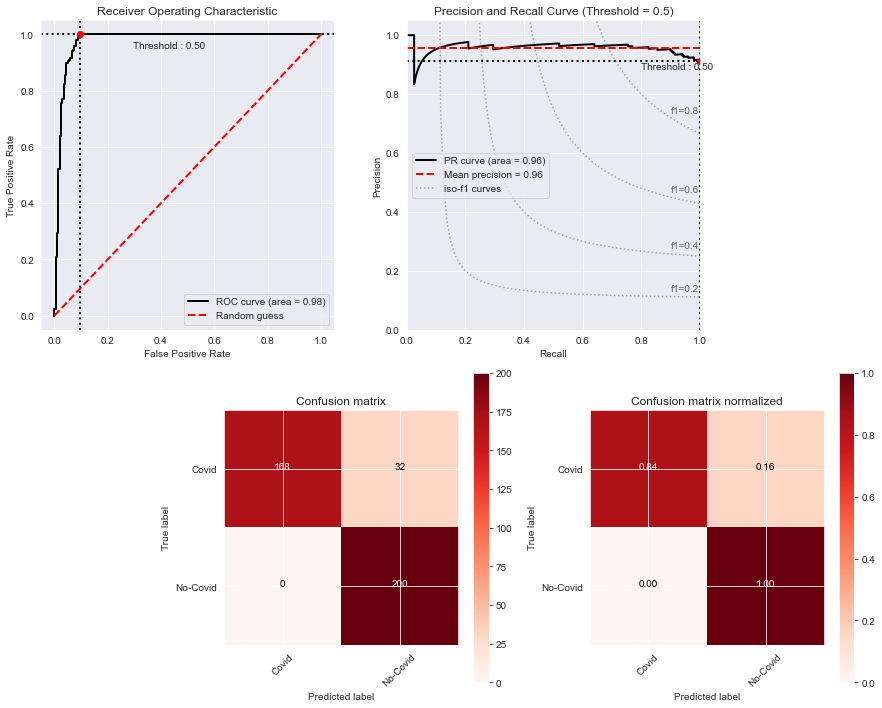

In [38]:
bc = BinaryClassification(y_test,y_pred_proba, labels) 
# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
#plt.subplot2grid((2,6), (0,4), colspan=2)
#bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()

In [39]:
model.save('X-Ray_1.0.hdf5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

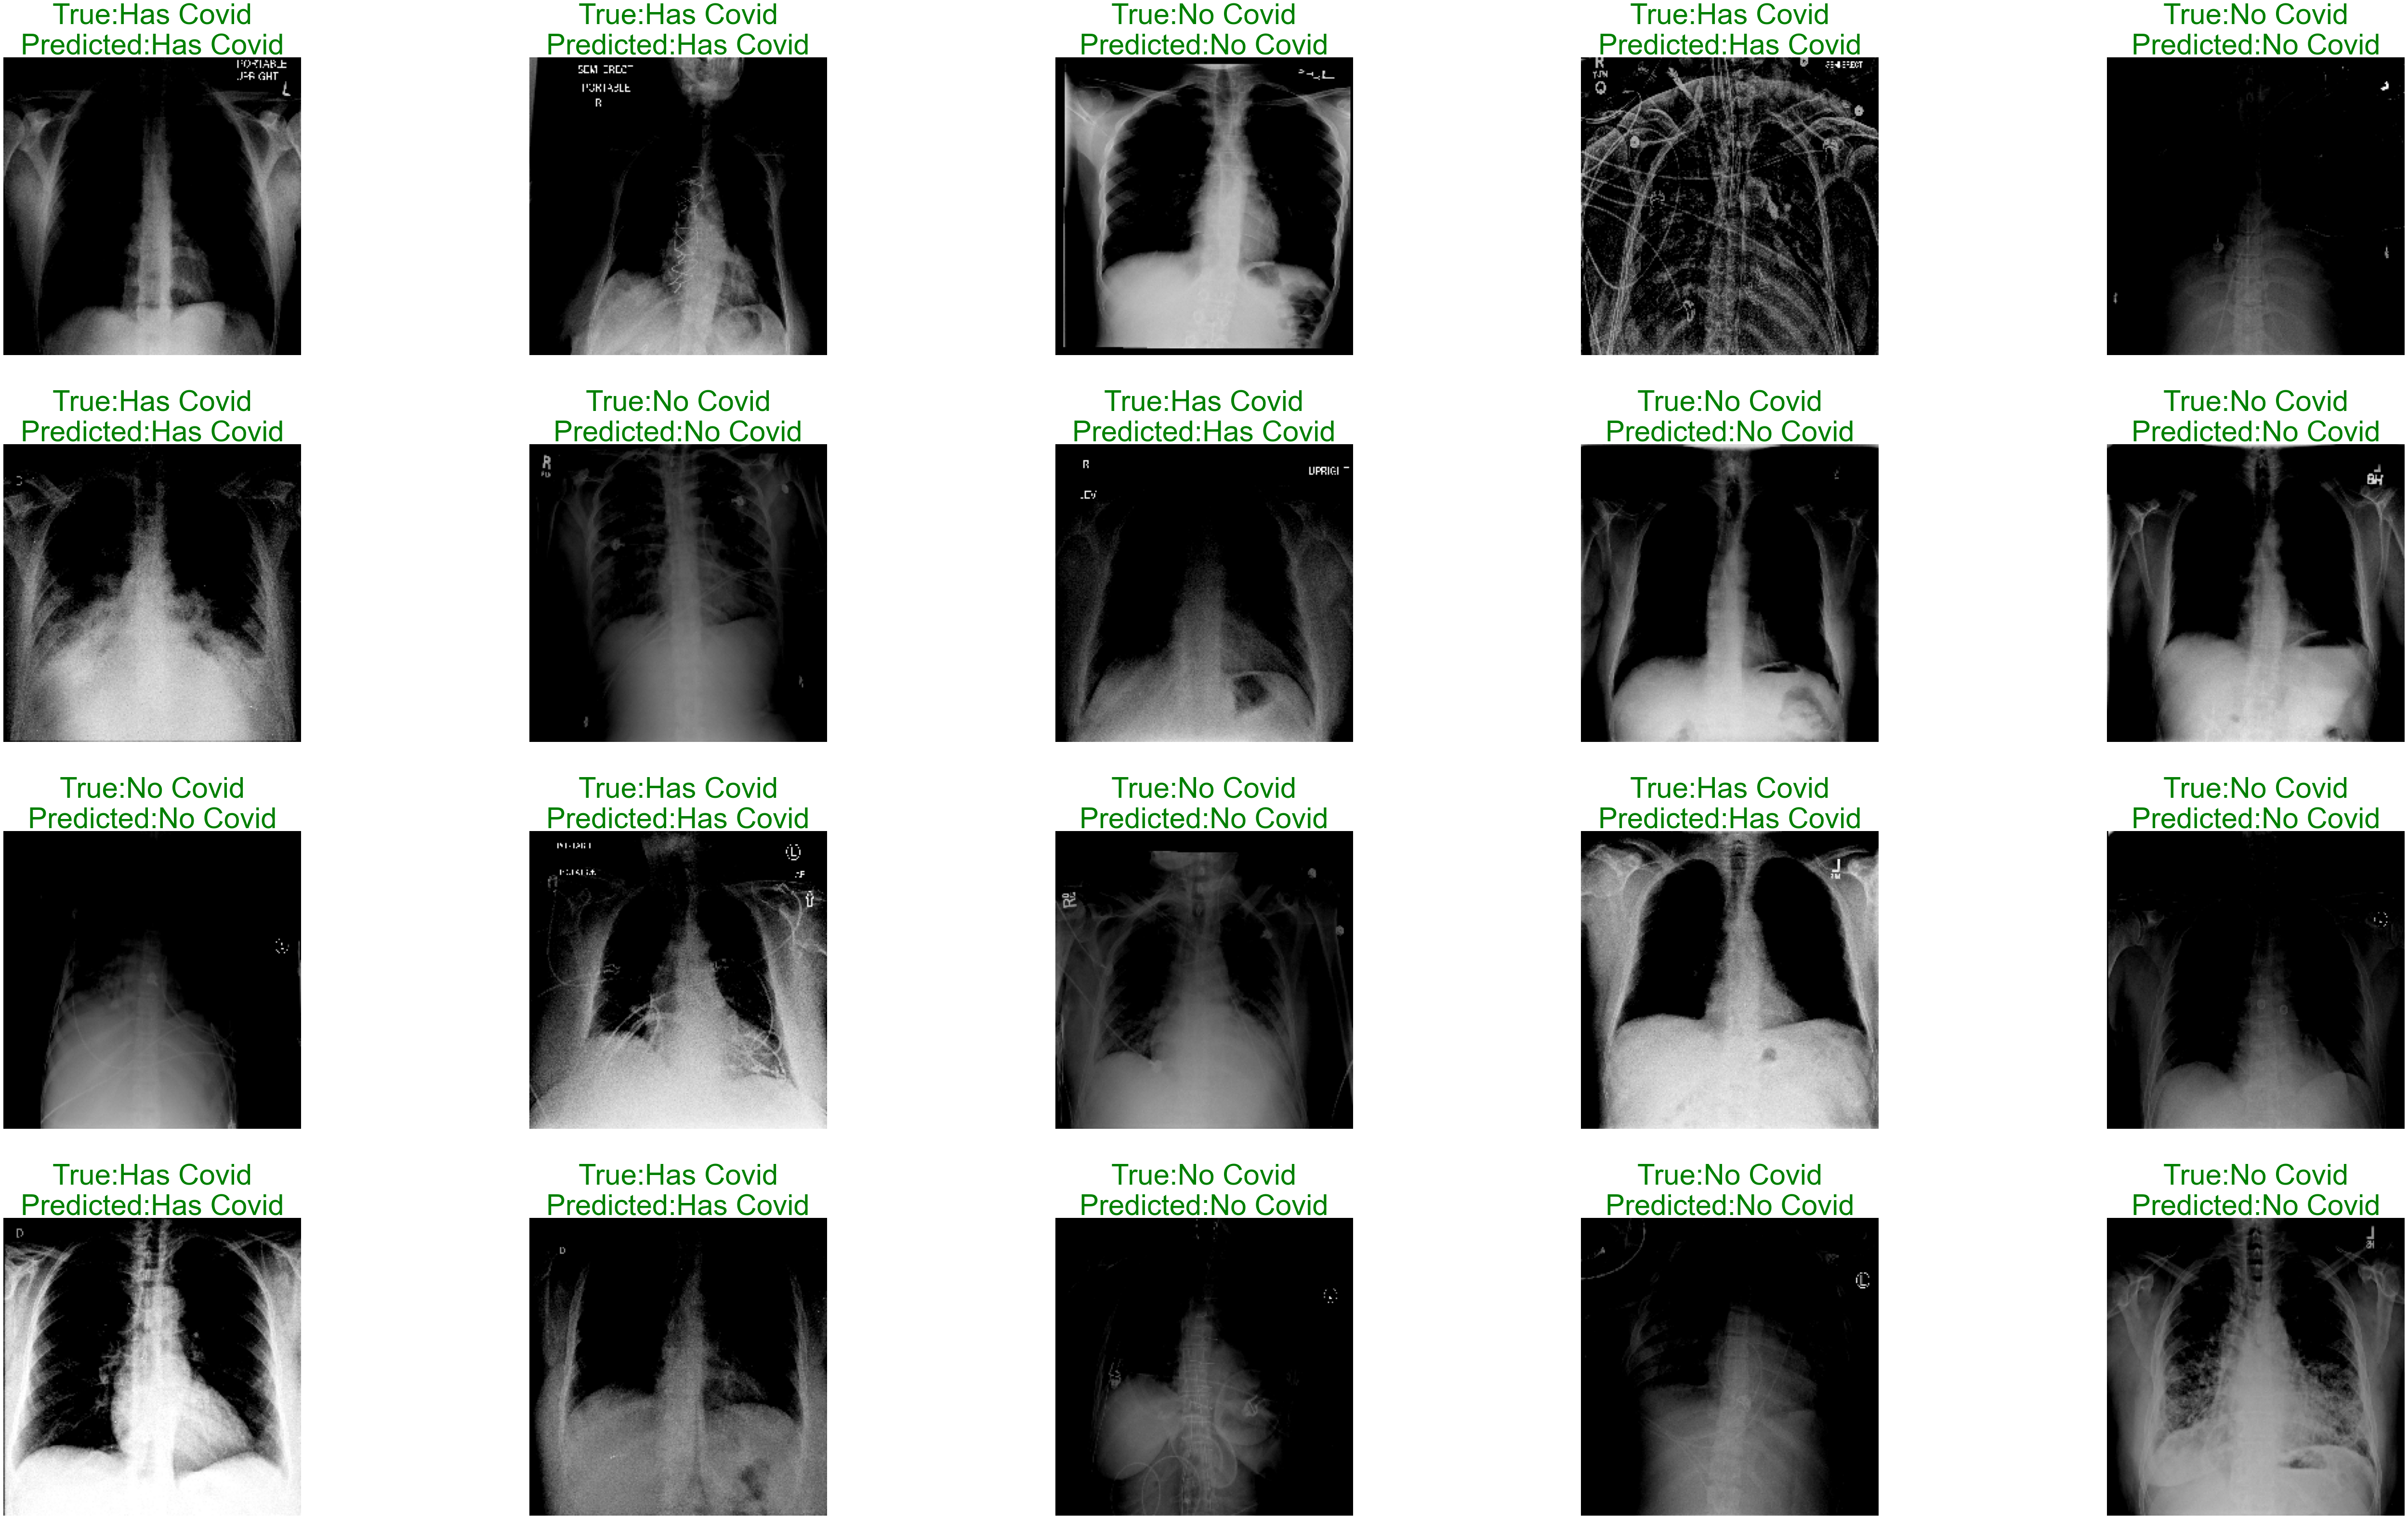

In [42]:
translator = {"1":"No Covid","0":"Has Covid"}

plt.figure(figsize=(100,100))
tempc = np.random.choice(x_test[y_test == y_pred_classes.ravel()].shape[0],20,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test == y_pred_classes.ravel()].shape[0])
    plt.imshow(x_test[y_test == y_pred_classes.ravel()][tempc])
    plt.title(f"True:{translator[str(y_test[y_test == y_pred_classes.ravel()][tempc])]}\nPredicted:{translator[str(y_pred_classes.ravel()[y_test == y_pred_classes.ravel()][tempc])]}",
              fontsize=60,color='g')
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

In [ ]:
#above is how we can evaluate if our labels (0,1) were chosen correctly